# Chapter 03

## MNIST

* Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset from OpenML.org:1

In [1]:
from sklearn.datasets import fetch_openml

mnist =fetch_openml('mnist_784', as_frame=False)

In [2]:
X,y =mnist.data, mnist.target

In [3]:
X.shape,y.shape

((70000, 784), (70000,))

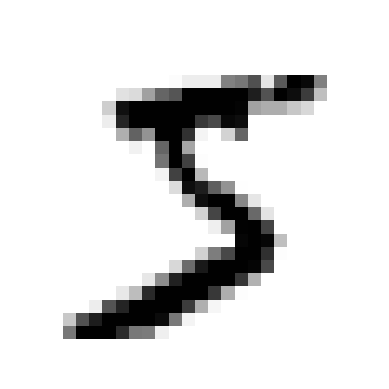

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image =image_data.reshape(28,28)
    plt.imshow(image,cmap='binary')
    plt.axis('off')

some_digit =X[0]
plot_digit(some_digit)
plt.show()

This looks like a 5, and indeed that’s what the label tells us

In [5]:
y[0]

'5'

In [6]:
X_train,X_test,y_train,y_test =X[:60000],X[60000:], y[:60000],y[60000:]

## Training a Binary Classifier

In [7]:
y_train_5 = (y_train == '5')
y_test_5 =(y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

In [9]:
sgd_clf =SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [10]:
# Now we can use it to detect images of the number 5:

sgd_clf.predict([some_digit])

array([ True])

## `Performance Measures`

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. There are many performance
measures available, so grab another coffee and get ready to learn a bunch of new
concepts and acronyms

`Measuring Accuracy Using Cross-Validation`

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3 ,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

* Make dummy classifier

In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf =DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [14]:
# Can you guess thise models accuracy? lets find out:

cross_val_score(dummy_clf, X_train,y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

`Implimenting Cross-Validation`

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds =StratifiedKFold(n_splits=3)  # add shuffle=True if the datasets is not alredy shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf =clone(sgd_clf)
    X_train_folds =X_train[train_index]
    y_train_folds =y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred =clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred ==y_test_fold)

    print(n_correct /len(y_pred))




0.95035
0.96035
0.9604


`Confusion Matrix`

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix()
function. Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
y_train_perfect_predictions =y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* The confusion matrix gives you a lot of information, but sometimes you may prefer
a more concise metric. An interesting one to look at is the accuracy of the positive
predictions; this is called the precision of the classifi

Equation 3-1. Precision

precision = TP/TP + FP

* Recall

recall = TP/Tp + FN

`Precision and Recall`

In [21]:
# Scikit-Learn provides several functions to compute classfier metrics, including precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred)

recall_score(y_train_5, y_train_pred)

0.6511713705958311

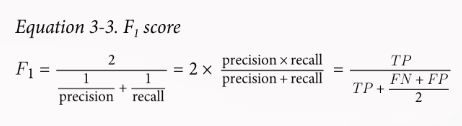

In [22]:
# To compute the F1 score, simply call the f1_score function

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

`The Precision/Recall Trade-Off`

Instead of calling the classifier’s predict() method, you can call its decision_func
tion() method, which returns a score for each instance. You can then use any
threshold you want to make predictions based on those scor

In [23]:
y_scores =sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshhold =0
y_some_digit_pred = (y_scores > threshhold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the
same result as the predict() method (i.e., True). Let’s raise the threshold

In [25]:
threshhold = 3000

y_some_digit_pred =(y_scores > threshhold)
y_some_digit_pred

array([False])

In [26]:
y_scores =cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds (the function adds a last precision of 1 and a last
recall of 0, corresponding to an infinite threshold):

In [47]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshhold =precision_recall_curve(y_train_5,y_scores)

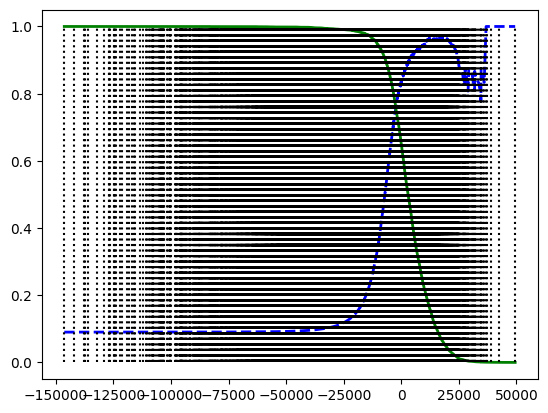

In [48]:
plt.plot(threshhold, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(threshhold, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshhold, 0, 1.0, "k", "dotted", label="threshold")
[...]
plt.show()

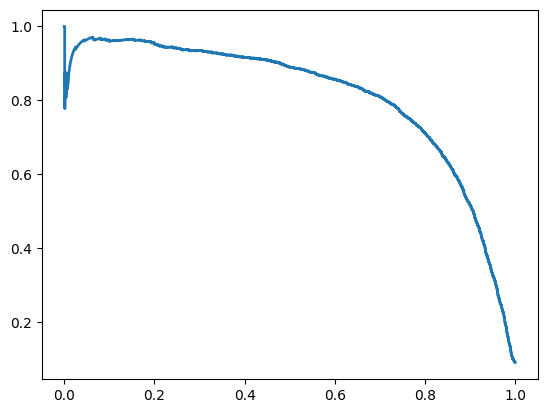

In [49]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
[...]
plt.show()

NumPy array’s argmax() method. This returns the first index of the maximum value,
which in this case means the first True value:

In [50]:
idx_for_90_precision = (precisions >=0.90).argmax()
threshold_for_90_precision =threshhold[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

To make predictions (on the training set for now), instead of calling the classifier’s
predict() method, you can run this code:

In [51]:
y_train_pred_90 =(y_scores >=threshold_for_90_precision)

Let's check these predictions precison and recall

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [53]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

* To plot the ROC curve, you first use the roc_curve() function to compute the TPR
and FPR for various threshold values:

In [54]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds =roc_curve(y_train_5, y_scores)

In [55]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()

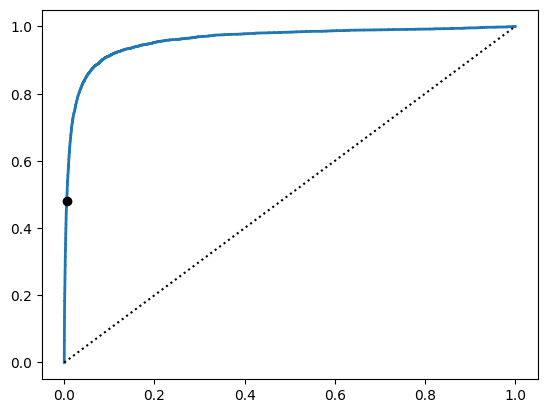

In [56]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
[...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can
compare to those of the SGDClassifi

In [58]:
from sklearn.ensemble import RandomForestClassifier
forest_clf =RandomForestClassifier(random_state=42)